In [1]:
import face_recognition as fr
import numpy as np
import cv2
import time
import os


def extract_features(img):
    try:
        face_bounding_boxes = fr.face_locations(img)
        # If training image contains exactly one face
        if len(face_bounding_boxes) == 1:
            face_enc = fr.face_encodings(img, face_bounding_boxes)[0]
        else:
            return
    except:
        return
    return face_enc


def load_dataset(pathname):
    X, y = [], []
    for label in sorted(os.listdir(pathname)):
        if label != '.DS_Store':
            path_img = os.path.join(pathname, label)
            for img in os.listdir(path_img):
                img = cv2.imread(os.path.join(path_img, img))
                features = extract_features(img)
                if features is not None:
                    X.append(features)
                    y.append(label)

    return np.array(X), np.array(y)


X, y = load_dataset('faces')

In [2]:
s_acc = s_loss = 0
def scorer(model, X_test, y_test):
    global s_acc, s_loss
    y_pred = model.predict(X_test)
    s_acc += accuracy_score(y_test, y_pred)

    y_pred = model.predict_proba(X_test)
    s_loss += log_loss(y_test, y_pred)
    return s_acc

def score_dataset(dataset_name, model, X, y, cv=None):
    global s_acc, s_loss
    if cv:
        s_acc = s_loss = 0
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        mean_acc = s_acc/cv
        mean_loss = s_loss/cv
        print("%12s %2d-folds = %.3f with loss = %.3f" % (dataset_name, cv, mean_acc, mean_loss))
        return mean_acc, mean_loss
    else:
        for nFold in range(2, 10+1):
            scores = cross_val_score(model, X, y, cv=nFold)
            print("%s %2d-folds = %.3f" % (dataset_name, nFold, np.mean(scores)))

In [3]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn import svm
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    'kNN': KNeighborsClassifier(n_neighbors=2),
    'GaussianNB': GaussianNB(),
    'DecisionTree': tree.DecisionTreeClassifier(criterion="gini"),
    'Bagging': BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(), n_estimators=100),
    'AdamBoost': AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=2), n_estimators=100),
    'RandomForest': RandomForestClassifier(n_estimators=50),
    'SVM_Linear': svm.SVC(kernel='linear', C=1000, probability=True),
    'SVM_Poly': svm.SVC(kernel='poly', C=100000, probability=True),
    'SVM_RBF': svm.SVC(kernel='rbf', C=100000, gamma=0.01, probability=True),
    'SVM_Sigmoid': svm.SVC(kernel='sigmoid', C=100000, gamma=0.0001, probability=True)
}

# Logging for Visual Comparison
log_cols=["Classifier", "Accuracy", "Log Loss"]
log = pd.DataFrame(columns=log_cols)

for model in models.items():
    mean_acc, mean_loss = score_dataset(model[0], model[1], X, y, cv=10)
    log_entry = pd.DataFrame([[model[0], mean_acc*100, mean_loss]], columns=log_cols)
    log = log.append(log_entry)

         kNN 10-folds = 1.000 with loss = 0.000
  GaussianNB 10-folds = 1.000 with loss = 0.000
DecisionTree 10-folds = 0.997 with loss = 0.113
     Bagging 10-folds = 0.999 with loss = 0.009
   AdamBoost 10-folds = 0.999 with loss = 0.003
RandomForest 10-folds = 1.000 with loss = 0.010
  SVM_Linear 10-folds = 1.000 with loss = 0.006
    SVM_Poly 10-folds = 1.000 with loss = 0.006
     SVM_RBF 10-folds = 1.000 with loss = 0.006
 SVM_Sigmoid 10-folds = 1.000 with loss = 0.006


In [4]:
print(log)
log.to_csv('log.csv', index=False)

     Classifier    Accuracy      Log Loss
0           kNN  100.000000  2.109424e-15
0    GaussianNB  100.000000  2.109424e-15
0  DecisionTree   99.673913  1.126264e-01
0       Bagging   99.891304  8.630681e-03
0     AdamBoost   99.890110  3.021964e-03
0  RandomForest  100.000000  1.047707e-02
0    SVM_Linear  100.000000  6.207276e-03
0      SVM_Poly  100.000000  6.085376e-03
0       SVM_RBF  100.000000  6.217288e-03
0   SVM_Sigmoid  100.000000  6.224435e-03


Text(0.5, 1.0, 'Classifier Log Loss')

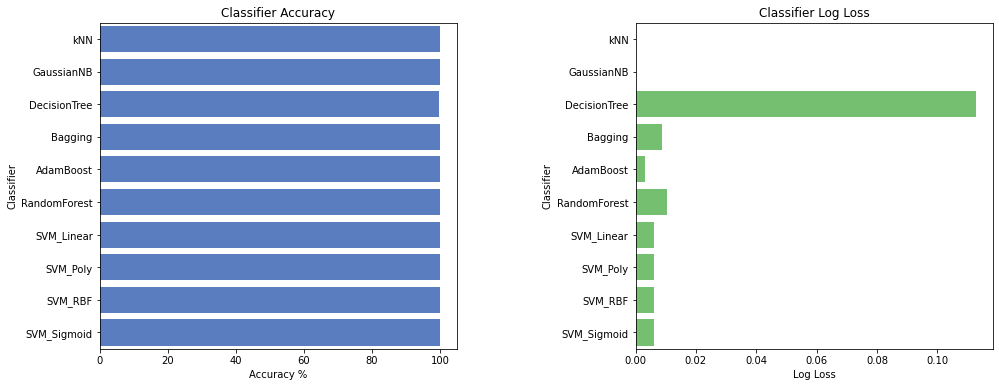

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 6)
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 1)
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")

plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
# plt.show()

plt.subplot(1, 2, 2)
sns.set_color_codes("muted")
sns.barplot(x='Log Loss', y='Classifier', data=log, color="g")

plt.xlabel('Log Loss')
plt.title('Classifier Log Loss')
# plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from joblib import dump

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=3./10, random_state=2020)
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(acc)
dump(clf, 'faces.model')

1.0


['faces.model']